<a href="https://colab.research.google.com/github/galievaz/ISAC/blob/master/Task2/1_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries and Data

In [ ]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

data = pd.read_csv("data-training (1).csv")
data.head()
 

,all,label,body_text
0,0 link to my webcam you wanted Wanna see sexu...,0,link to my webcam you wanted Wanna see sexual...
1,1 Re: How to manage multiple Internet connecti...,1,Re: How to manage multiple Internet connection...
2,0 [SPAM] Give her 3 hour rodeo Enhance your d...,0,[SPAM] Give her 3 hour rodeo Enhance your des...
3,0 Best Price on the netf5f8m1 (suddenlysusan@...,0,Best Price on the netf5f8m1 (suddenlysusan@St...
4,1 linux.ie mailing list memberships reminder T...,1,linux.ie mailing list memberships reminder Thi...


In [ ]:
data['label'].value_counts()

1          2799
0          1291
nd            1
m             1
#VALUE!       1
Name: label, dtype: int64

### Preprocessing Data

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer() #

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\128524\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Split into train/test

In [ ]:
from sklearn.model_selection import train_test_split

X=data[['body_text', 'body_len', 'punct%']]
y=data['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Vectorize text

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,78579,78580,78581,78582,78583,78584,78585,78586,78587,78588
0,460,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,519,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,200,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1529,9.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16729,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Final evaluation of models

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns

Precision: 0.987 / Recall: 0.874 / F1-Score: 0.927 / Accuracy: 0.955


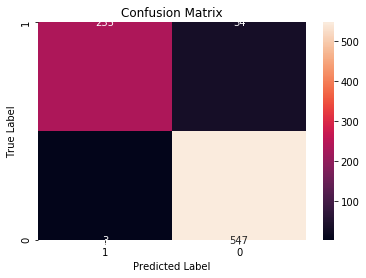

In [ ]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='0', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred), 3)))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_label = ["1", "0"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()